# 오디오 처리(Audio Processing)

* 소리는 진동으로 인한 공기의 압축으로 생성
* 압축이 얼마나 됬느냐에 따라 진동하며, 공간이나 매질을 전파해 나가는 현상인 Wave(파동)으로 표현
* 파동에서 얻을 수 있는 정보
  + 위상(Phase; Degress of displacement)
  + 진폭(Amplitude; Intensity)
  + 주파수(Frequency)

![](https://miro.medium.com/max/700/0*QFVha2lCgyhKjhuO.gif)





## 오디오 라이브러리

* librosa는 각종 음성 처리에 유용한 라이브러리
* colab 환경에서 torchaudio는 별도 설치가 필요
* 해당 예제에서는 torchaudio를 이용해 음성 데이터를 가져옴

In [ ]:
!pip install torchaudio #음성데이터 가져오기 위해 설치

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

import librosa
import librosa.display
import torch
import torchaudio
import IPython.display as ipd

<ipython-input-2-2b8ad6e4d21f>:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


## 오디오 데이터

*   pytorch의 torchaudio를 사용해 내장 데이터셋을 가져옴
*   데이터가 크기 때문에 시간이 많이 소요

In [ ]:
train_dataset = torchaudio.datasets.LIBRISPEECH("./", url="train-clean-100", download=True)
test_dataset = torchaudio.datasets.LIBRISPEECH("./", url="test-clean", download=True)
#오디오만으로도 용량이 굉장히

100%|██████████| 5.95G/5.95G [04:09<00:00, 25.6MB/s]
100%|██████████| 331M/331M [00:17<00:00, 19.6MB/s]




*   불러온 데이터 확인
  *   첫번째 줄에서는 소리 데이터 확인 가능
  *   두번째 줄에선 해당 데이터의 sampling rate 확인 가능





In [ ]:
test_dataset[1]
#파이토치 텐서의 구조로 오디오 데이터가 나옴.16000이 샘플링레이트임

(tensor([[ 0.0010,  0.0011,  0.0009,  ..., -0.0007, -0.0010, -0.0011]]),
 16000,
 'STUFF IT INTO YOU HIS BELLY COUNSELLED HIM',
 1089,
 134686,
 1)



*   불러온 데이터의 형상을 확인
*   데이터 길이만으로는 음성이 몇초에 해당하는지(duration)를 알 수 없음



In [ ]:
test_dataset[1][0].shape #두번째 값이 쉐잎

torch.Size([1, 52400])

## 샘플링(Sampling)

### Sampling

* 음성을 처리하기 위해 아날로그 정보를 잘게 쪼개 이산적인 디지털 정보로 표현해야 함
* 이때 무한히 쪼개서 저장할 수는 없으므로, 기준을 세워 아날로그 정보를 쪼개 대표값을 사용, 이를 샘플링이라 함
* 주로 사용할 때 시간을 기준으로 아날로그 정보를 쪼개는 Time Domain 방식을 사용

* Sampling rate
  * sampling rate는 아날로그 정보를 얼마나 잘게 쪼갤지를 결정
  * 잘게 쪼갤수록 정보 손실이 줄어들지만, 데이터의 크기가 늘어남
* Sampling theorem
  * sampling rate가 최대 frequency보다 2배 커져야 함을 의미
  * 일반적으로 sampling은 인간의 청각 영역에 맞게 형성
    - Audio CD : 44.1 kHz(44100 sample/second)
    - Speech communication : 8 kHz(8000 sample/second)







*   음성의 duration은 데이터의 길이와 sampling rate를 나누어 확인 가능


In [ ]:
audio_data = test_dataset[1][0][0]
sr = test_dataset[1][1]

print(audio_data, sr)
print('length:', len(audio_data))
print('duration:', len(audio_data) / sr)

ipd.Audio(audio_data, rate=sr)

tensor([ 0.0010,  0.0011,  0.0009,  ..., -0.0007, -0.0010, -0.0011]) 16000
length: 52400
duration: 3.275


### Resampling

* Resampling은 sampling data의 sampling rate를 조정해 다시 sampling하는 것
* 이때 일반적으로 보간(interpolation)을 할때는 low-pass filter를 사용
* `librosa.resample`을 사용하면 편리하게 resampling 가능
* 현재 데이터는 `torch tensor`, `librosa`는 `numpy` 배열을 받아들이기 때문에 변환 필요
* sampling rate를 절반으로 줄여, 길이도 절반으로 준 것을 확인할 수 있음


In [ ]:
#보간법 - 로우패스필터 사용해서(ex.높은 주파수대 영역들)보간을 시킨다.
#16000의 샘플링 레이트를 8천으로 줄임
#16000과 차이는 소리가 전화 통화에서 들리는 소리, 오리지널과 차이 존재 -> 어눌해짐
#즉, 적게 쪼갤수록 음질이 좋지 않아짐

# audio_np = audio_data.numpy()
# y_8k = librosa.resample(audio_np, orig_sr=sr, target_sr=8000)

# print(len(audio_np), len(y_8k))
# ipd.Audio(y_8k, rate=8000)

###############반 줄임 ###################

audio_np = audio_data.numpy()
y_4k = librosa.resample(audio_np, orig_sr=sr, target_sr=4000)

print(len(audio_np), len(y_4k))
ipd.Audio(y_4k, rate=4000)

52400 13100


### Normalization & Quantization

*   데이터간 음량이 제각각인 경우 normalization을 하여 amplitude를 [-1, 1] 범위로 조정
*   여기서는 가장 간단한 방법인 데이터의 최대값으로 나눠주는 방법을 사용



    *   정규화: 절대값의 최대값을 나눠줌, 큰 차이가 나진 않음
    *   퀀티제이션: 음질 저하, 노이즈 상승




In [ ]:
audio_np = audio_data.numpy()
normed_wav = audio_np / max(np.abs(audio_np))
ipd.Audio(normed_wav, rate = sr)

노이즈 심해짐, 음질 저하 , 용량은 적어짐

In [ ]:
bit = 8
max_value = 2 ** (bit-1) #2의 7승

quantized_8_wav = normed_wav * max_value
quantized_8_wav = np.round(quantized_8_wav).astype(int) #반올림처리
quantized_8_wav = np.clip(quantized_8_wav, -max_value, max_value-1)
ipd.Audio(quantized_8_wav, rate=sr)

### Mu-Law Encoding

* 사람의 귀는 작은소리의 차이는 잘잡아내는데 반해 소리가 커질수록 그 차이를 잘 느끼지 못함
* 이러한 특성을 wave값을 표현하는데 반영해 작은 값에는 높은 분별력을, 큰 값끼리는 낮은 분별력을 갖도록 함


    *   사람의 귀에 적합하도록 만들어 준다. 손실 존재하긴 함. 소리가 커짐    




In [ ]:
def mu_law(x, mu = 255):
    return np.sign(x) * np.log(1+ mu * np.abs(x)) / np.log(1+mu)

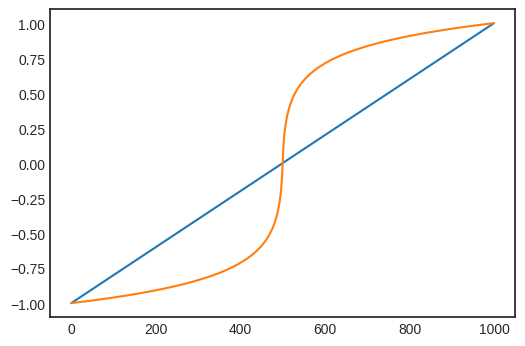

In [ ]:
x = np.linspace(-1, 1, 1000)
x_mu = mu_law(x)

plt.figure(figsize=[6, 4])
plt.plot(x)
plt.plot(x_mu)
plt.show()

In [ ]:
wav_mulaw = mu_law(normed_wav)
ipd.Audio(wav_mulaw, rate=sr)

# 오디오 표현(Audio Representation)

* Sampling된 discrete한 데이터를 표현
  + 시간의 흐름에 따라, 공기의 파동의 크기로 보는 Time-Domain Representation 방법
  + 시간에 따라서 frequency의 변화를 보는 Time-Frequency Representation

## Waveform - Time-Domain Representation

* Waveform은 오디오의 자연적인 표현
* 시간이 x축으로 그리고 amplitude가 y축으로 표현

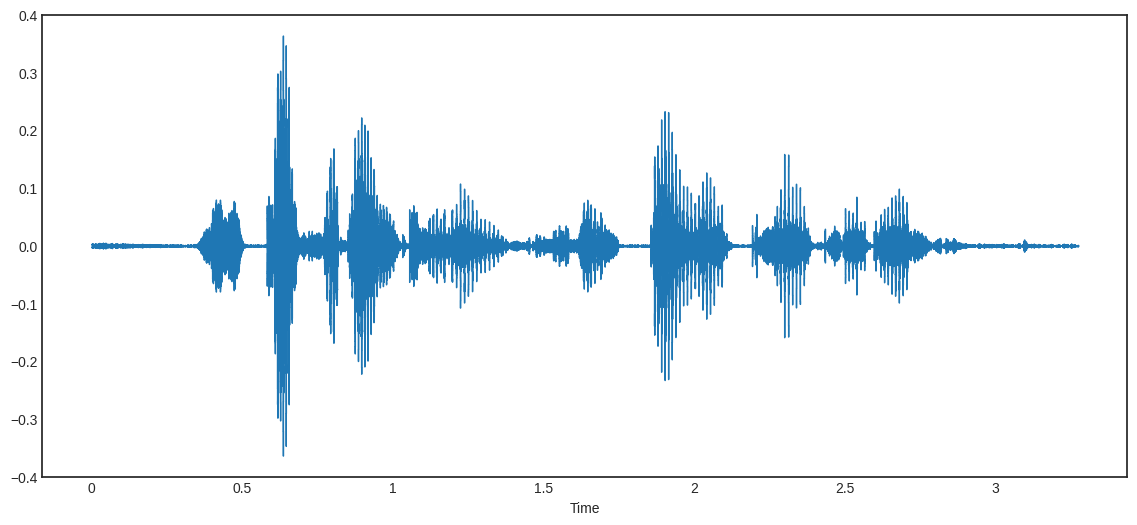

In [ ]:
audio_np = audio_data.numpy()

fig = plt.figure(figsize=(14, 6))
librosa.display.waveshow(audio_np[0:100000], sr=sr);

## 정현파(Sinusoid) - Time-Frequency Representation

![](https://upload.wikimedia.org/wikipedia/commons/6/61/FFT-Time-Frequency-View.png)

* 모든 신호는 주파수(frequency)와 크기(magnitude), 위상(phase)이 다른 정현파(sinusolida signal)의 조합으로 나타낼 수 있음
* 퓨리에 변환은 조합된 정현파의 합(하모니) 신호에서 그 신호를 구성하는 정현파들을 각각 분리해내는 방법

In [ ]:
def Sinusoid(A, f, phi, fs, t):
    t = np.arange(0, t, 1.0/fs)
    x = A * np.cos(2*np.pi*f*t+phi)
    return x

In [ ]:
A = 0.9
f = 340 #계이름 '라'정도를 의미
phi = np.pi/2
fs = 22050
t = 1

In [ ]:
sin = Sinusoid(A, f, phi, fs, t)

In [ ]:
A = 0.9
f = 260
phi = np.pi/2
fs = 22050
t = 1

In [ ]:
sin2 = Sinusoid(A, f,phi, fs, t)

In [ ]:
complexwav = sin + sin2

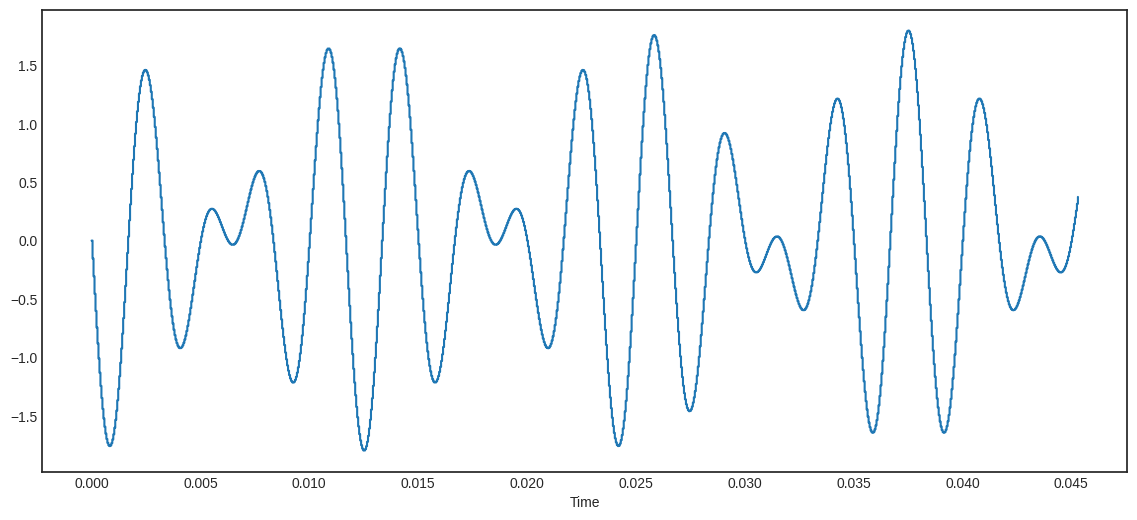

In [ ]:
fig = plt.figure(figsize=(14, 6))
librosa.display.waveshow(complexwav[0:1000], sr=fs);

In [ ]:
#sin 1초 들어보기
ipd.Audio(sin +sin/2 +sin/4, rate=fs)

In [ ]:
#sin2 들어보기
ipd.Audio(sin2 +sin2/2 +sin2/4, rate=fs)

In [ ]:
def generate_sinusoid_scale(pitches=[69], duration = 0.5, fs = 22050, amplitude_max=0.5):
    N = int(duration * fs)
    t = np.arange(N) /fs
    x = []
    for p in pitches:
        omega = 2 ** (( p- 69) /12) *440
        x = np.append(x, np.sin(2* np.pi * omega * t))
    x = amplitude_max * x / np.max(x)
    return x


pitches 피치 값이 커질 수록 음이 높아졌음

In [ ]:
duration = 1
fs =22050
pitches = [36, 48, 60, 72 , 84, 96]
x = generate_sinusoid_scale(pitches = pitches, duration=duration, fs= fs)
print('Pitch class C = {..., C1, C2,C3, C4, C5, C6, ......}')
ipd.Audio(data=x, rate=fs)

Pitch class C = {..., C1, C2,C3, C4, C5, C6, ......}


## 푸리에 변환(Fourier Fransform)


* 푸리에 변환은 임의의 입력 신호를 다양한 주파수를 갖는 주기 함수들의 합으로 분해하여 표현하는 것을 의미
* 푸리에 변환 식
$$
A_k = \frac{1}{T} \int_{-\frac{T}{2}}^\frac{T}{2} f(t) \, \exp \left( -i\cdot 2\pi \frac{k}{T} t \right) \, dt
$$
$$
y(t)=\sum_{k=-\infty}^\infty A_k \, \exp \left( i\cdot 2\pi\frac{k}{T} t \right)
$$



* 위 식에는 주기 함수들은 포함되어 있지 않음
* 오일러 공식에 따라 다음과 같이 지수 함수와 주기 함수간 관계를 나타낼 수 있음
$$
e^{i\theta} = \cos{\theta} + i\sin{\theta}
$$

* 해당 식을 오일러 공식에 따라 다음과 같이 표현 가능

$$
\exp \left( i\cdot 2\pi\frac{k}{T} t \right) = \cos\left({2\pi\frac{k}{T}}\right) + i\sin\left({2\pi\frac{k}{T}}\right)
$$

*   결국 푸리에 변환은 입력 신호에 상관없이 sin, cos 같은 주기 함수들의 합으로 분해 가능함을 나타냄

### 이산 푸리에 변환(Discrete Fourier Transform, DFT)



*   우리가 샘플링한 데이터는 discrete data라고 할 수 있음
*   위의 푸리에 변환을 이산 영역으로 생각해볼 수 있음
*   우리가 수집한 데이터 $y_n$에서 이산 시계열 데이터가 주기 N으로 반복한다고 할때, DFT는 주파수와 진폭이 다른 N개의 사인 함수 합으로 표현 가능
$$
y_n = \frac{1}{N} \sum_{k=0}^{N-1} Y_k \cdot \exp \left( i\cdot 2\pi\frac{k}{N} n \right)
$$

*   위 식을 보면 k의 range가 0부터 $N-1$로 변화했음을 알 수 있음
*   이때 Spectrum $Y_{k}$는 원래의 시계열 데이터에 대한 퓨리에 변환값

$$
Y_k = \sum_{n=0}^{N-1} y_n\cdot \exp \left( -i\cdot 2\pi\frac{k}{N} n \right)
$$

  * $y_{n}$ : input signal
  * $n$ : Discrete time index
  * $k$ : discrete frequency index
  * $Y_{k}$ : k번째 frequeny에 대한 Spectrum의 값



* DFT 수식을 코드로 나타내면 다음과 같음

In [ ]:
def DEF(x):
    N = len(x)
    X = np.array([])
    nv = np.arrange(N)

    for k in range(N):
        s = np.exp(1j * 2 * np.pi * k / N * nv)
        X = np.append(X, sum(x * np.conjugate(s)))
    return X

### Short-Time Fourier Transform(STFT)



*   DFT는 시간에 흐름에 따라 신호의 수파수가 변했을때, 어느 시간대에 주파수가 변하는지 모름
*   STFT는 시간의 길이를 나눠서 이제 퓨리에 변환
*   주파수의 특성이 시간에 따라 달라지는 사운드를 분석하는 방법이며 우리가 사용하는 signal 데이터에 적합
*   시계열 데이터를 일정한 시간 구간 (window size)로 나누고, 각 구간에 대해서 스펙트럼을 구함

*   STFT에 대한 식과 설명은 다음과 같음

$$
X(l,k) = \sum_{n=0}^{N-1} w(n) x(n+lH)\exp^{\frac{-2\pi k n}{N}}
$$

- $N$ : FFT size
    - Window를 얼마나 많은 주파수 밴드로 나누는가

- Duration
    - 샘플링 레이트를 window로 나눈 값
    - $T= window/SR$
    - T(Window) = 5T(Signal), duration은 신호주기보다 5배 이상 길게 잡아야함
    - 440Hz 신호의 window size는 5*(1/440)

- $w(n)$ : Window function
    - 일반적으로 Hann window 사용

- $n$ : Window size
    - Window 함수에 들어가는 Sample의 양
    - 작을수록 Low-frequency resolution을 가지게 되고, high-time resolution을 가짐
    - 길수록 High-frequency, low time resolution을 가짐
    
- $H$ : Hop size
    - 윈도우가 겹치는 사이즈, 일반적으로는 1/4정도를 겹치게 함

* STFT의 결과는 즉 시간의 흐름(Window)에 따른 Frequency영역별 Amplitude를 반환



In [ ]:
print(audio_np.shape, sr)

(52400,) 16000


In [ ]:
S = librosa.core.stft(audio_np, n_fft=1024, hop_length=512, win_length=1024)
print(S.shape, len(S[0]), S[0][0])
#푸리에 변환이 된 결과, input 쉐이프가 굉장히 중요함

(513, 103) 103 (0.022626022+0j)


In [ ]:
D = np.abs(S) ** 2
print(D.shape)

(513, 103)


<ipython-input-43-d437113cd25a>:1: UserWarning: power_to_db was called on complex input so phase information will be discarded. To suppress this warning, call power_to_db(np.abs(D)**2) instead.
  log_S = librosa.power_to_db(S, ref = np.max) #db()는 파워스펙토그램을 데시벨로 바꿔주는 함수


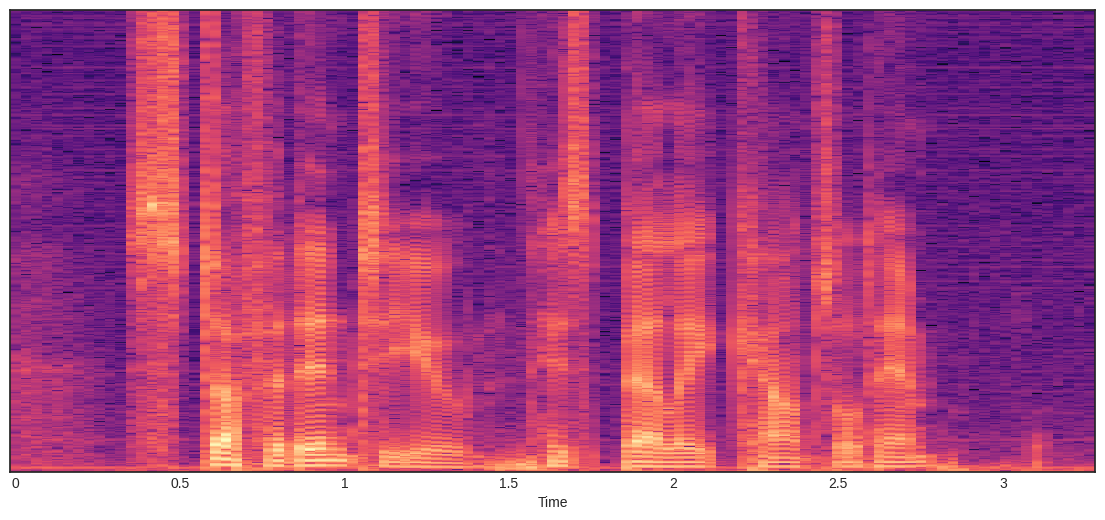

In [ ]:
log_S = librosa.power_to_db(S, ref = np.max) #db()는 파워스펙토그램을 데시벨로 바꿔주는 함수
plt.figure(figsize=(14, 6))
librosa.display.specshow(log_S, sr=16000, x_axis ='time' )

#### 윈도우 함수(Window Function)

* Window function 기능
  1. main-lobe를 제어
  2. side-lobe의 레벨 trade-off를 제어
  3. 깁스 현상(불연속을 포함하는 파형이 푸리에 합성되었을 때 불연속 값에서 나타나는 불일치 현상) 방지



In [ ]:
def frame_audio(audio, fft_size=1024, hop_size=20, sample_rate=22050):
    audio = np.pad(audio, int(fft_size/2), mode = "reflect")
    frame_len = np.round(sample_rate * hop_size / 1000).astype(int)
    frame_num = int((len(audio) - fft_size) / frame_len) + 1
    frames = np.zeros((frame_num, fft_size))

    for n in range(frame_num):
        frames[n] = audio[n*frame_len:n*frame_len+fft_size]
    return frames
audio_framed = frame_audio(audio_np)
print("Frmaed audio shape: {}".format(audio_framed.shape))

Frmaed audio shape: (119, 1024)


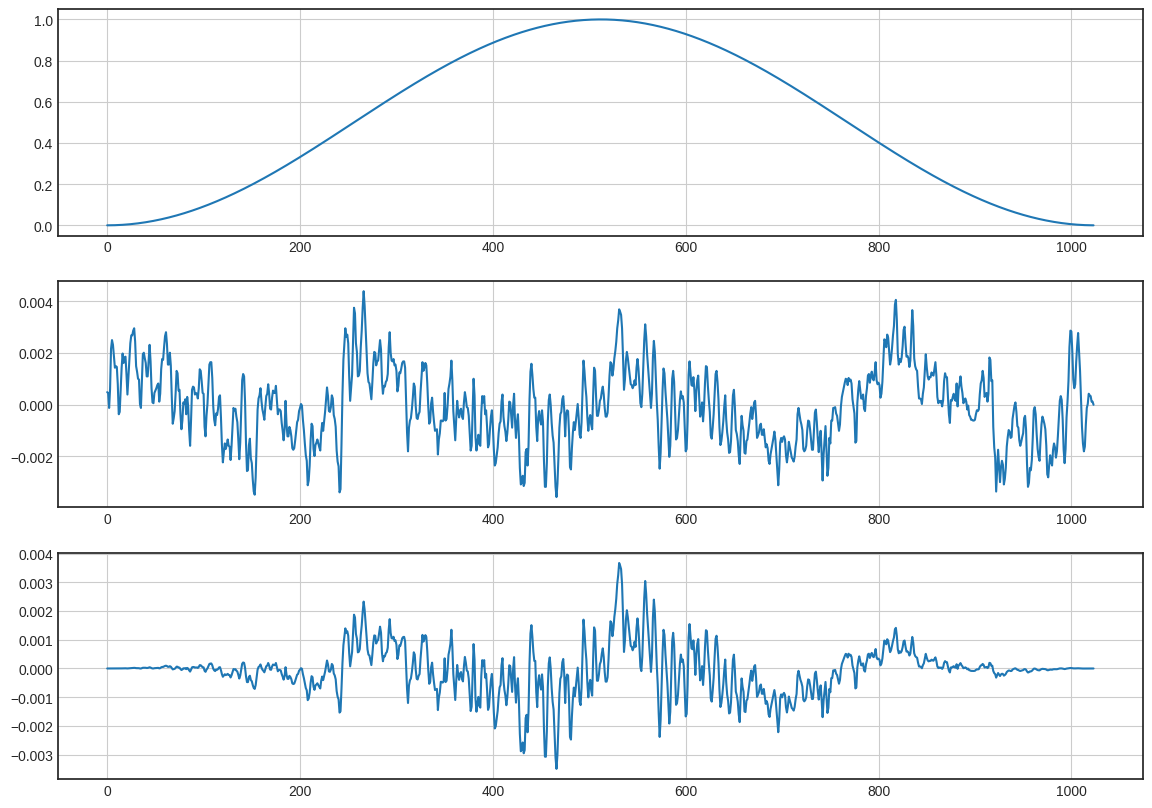

In [ ]:
from scipy import signal

window = signal.get_window("hann", 1024, fftbins =True)
audio_win = audio_framed * window
idx = 3

plt.figure(figsize=(14, 10))
plt.subplot(3, 1, 1)
plt.plot(window)
plt.grid(True)

plt.subplot(3, 1, 2)
plt.plot(audio_framed[idx])
plt.grid(True)

plt.subplot(3,1,3)
plt.plot(audio_win[idx])
plt.grid(True)

plt.show()

#### 윈도우 크기(Window Size)




*   window size는 time과 frequency의 resolutions를 제어
  * short-window - 낮은 frequency resolutuon, 높은 time resolution
  * long-window - 높은 frequency resolution, 낮은 time resolution



## 스펙트로그램(Spectrogram)

* 스펙트로그램은 소리나 파동을 시각화하여 파악하기 위한 도구
* 파형과 스펙트럼의 특징이 조합되어 있음
* 시간 축과 주파수 축의 변화에 따라 진폭의 차이를 인쇄 농도나 표시 색상 차이로 표현



### Linear Frequency Scale



*   순음(single tone)들의 배음 구조를 파악하는데 적절
*   분포가 저주파수 영역에 치우쳐져 있음



### 멜 스케일(Mel Scale)



*   주파수 단위를 다음 공식에 따라 멜 스케일로 변환
$$
m = 2595 \log_{10}\left(1 + \frac{f}{700}\right)
$$
*   일반적으로 mel-scaled bin을 FFT size보다 조금 더 작게 만듬
*   해당 scale을 적용해 spectogram을 만든 것이 melspectogram


In [ ]:
S= librosa.core.stft(audio_np, n_fft=1024, hop_length=512, win_length=1024)
D = np.abs(S) ** 2

In [ ]:
mel_basis = librosa.filters.mel(sr=sr, n_fft=1024, n_mels=40)
mel_S = np.dot(mel_basis, D)
print(mel_S.shape)

(40, 103)


멜 스케일 적용한 멜스펙트로그램

색상과 농도를 다르게하여 시각화

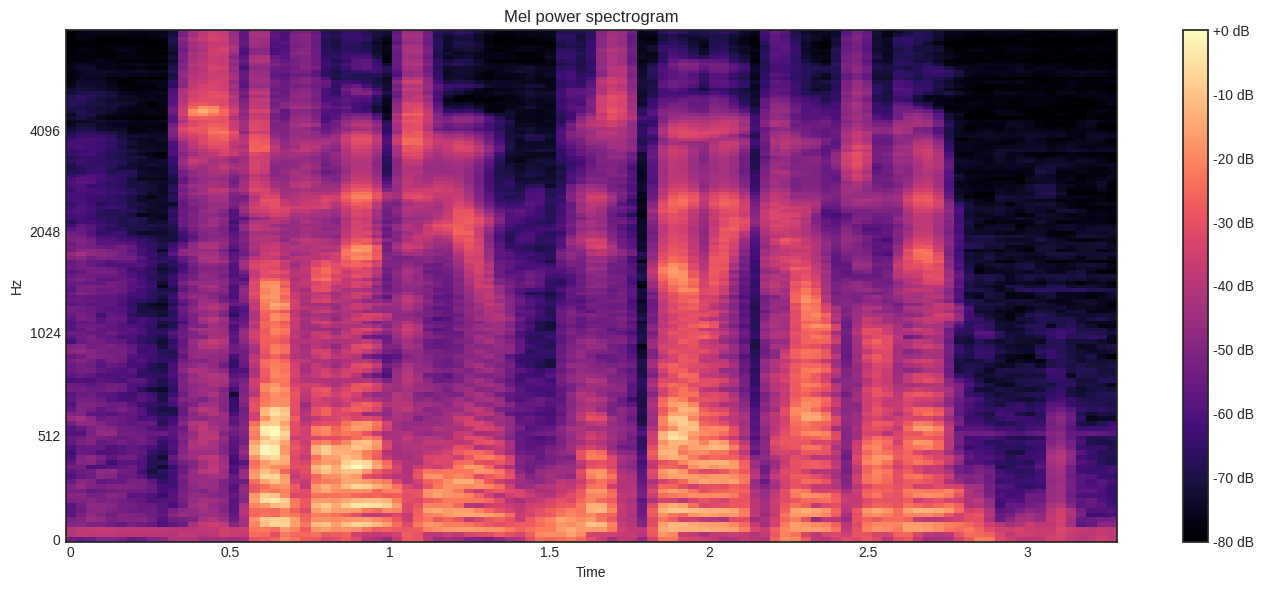

In [ ]:
S = librosa.feature.melspectrogram(y=audio_np, sr=sr, n_mels=128)
log_S = librosa.power_to_db(S, ref=np.max)
plt.figure(figsize=(14, 6))
librosa.display.specshow(log_S, sr=sr, x_axis = 'time', y_axis='mel')
plt.title('Mel power spectrogram')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()

### 바크 스케일(Bark Scale)

* 귀가 인식하는 주파수의 영역은 대략 $20Hz~2000Hz$로 가정, 하지만 주파수에 대한 사람의 인식은 비선형적
* 귀와 뇌의 가청대역을 24개의 대역으로 나눈것을 Bark라고 함
* Bark scale은 $500Hz$ 이하에서는 $100Hz$의 대역폭을, $500Hz$ 이상에서는 각 대역의 중심수파수의 대략 20%에 해당하는 대역폭을 가짐
  
  `20, 100, 200, 300, 400, 510, 630, 770, 920, 1080, 1270, 1480, 1720, 2000, 2320, 2700, 3150, 3700, 4400, 5300, 6400, 7700, 9500, 12000, 15500 ( Hz )`헤르츠

### Log Compression



*   신호를 $ 10 * log10(\frac{S}{ref})$의 단위로 신호를 스케일링
*   spectrogram을 데시벨 유닛으로 전환


In [ ]:
log_mel_S = librosa.power_to_db(mel_S)
print(log_mel_S.shape)

(40, 103)


## 이산 코사인 변환(Discrete Cosine Transform, DCT)



*   DCT는 n개의 데이터를 n개의 코사인 함수의 합으로 표현하여 "데이터의 양을 줄이는 방식"
*   저 주파수에 에너지가 집중되고 고 주파수 영역에 에너지가 감소

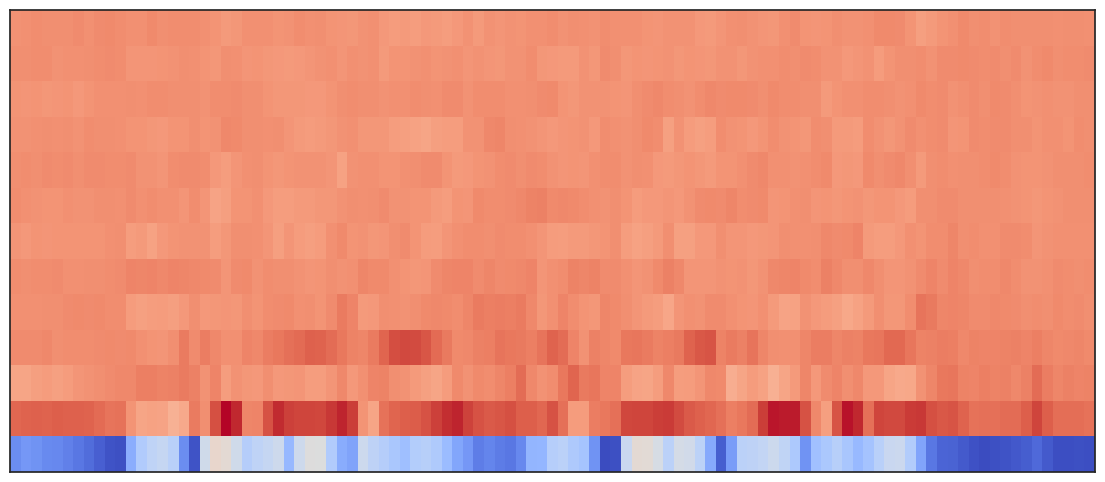

In [ ]:
mfcc = librosa.feature.mfcc(S=log_mel_S, n_mfcc=13)
mfcc = mfcc.astype(np.float32)
plt.figure(figsize=(14, 6))
librosa.display.specshow(mfcc);

(13, 103)


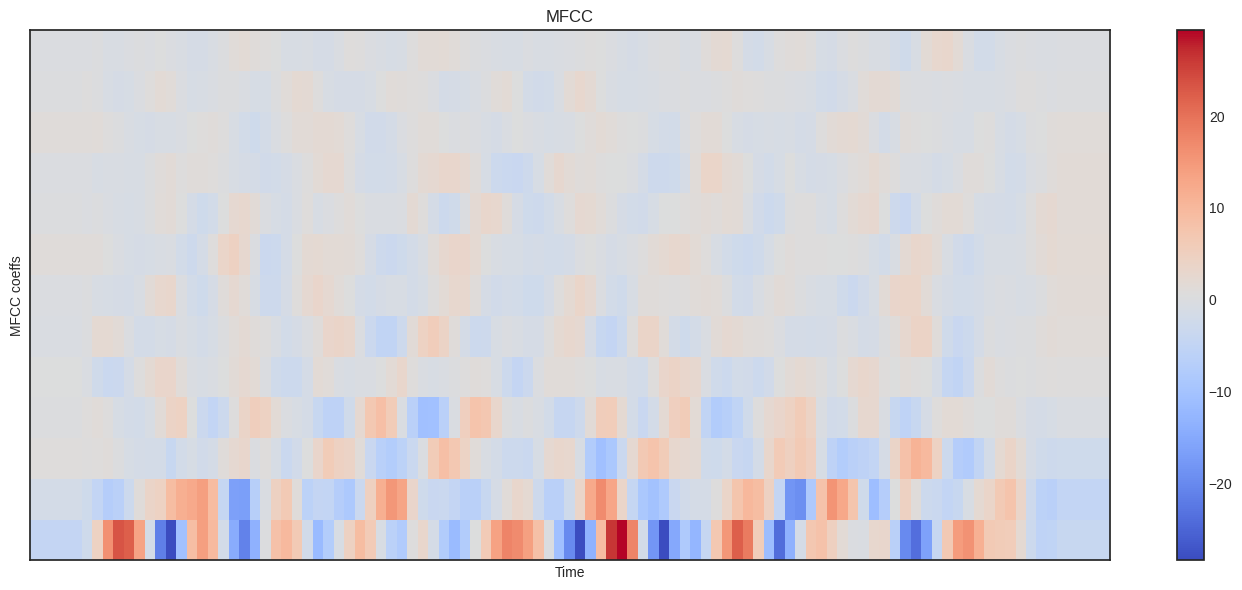

In [ ]:
mfcc = librosa.feature.mfcc(S=log_S, n_mfcc=13)
delta2_mfcc = librosa.feature.delta(mfcc, order=2)
print(delta2_mfcc.shape)

plt.figure(figsize=(14, 6))
librosa.display.specshow(delta2_mfcc)
plt.ylabel('MFCC coeffs')
plt.xlabel('Time')
plt.title('MFCC')
plt.colorbar()
plt.tight_layout()

## 오디오 특징 추출(Audio Feature Extraction)

* 모든 오디오 신호는 많은 특징(피쳐)으로 구성
* 해결하려는 문제와 관련된 특성 추출 필요

### 스펙트럼 센트로이드(Spectral Centroid)

* 주파수의 스펙트럼의 가중 평균과 같음

In [ ]:
spectral_centroids = librosa.feature.spectral_centroid(y=audio_np, sr=sr)[0]
print(spectral_centroids.shape)

(103,)


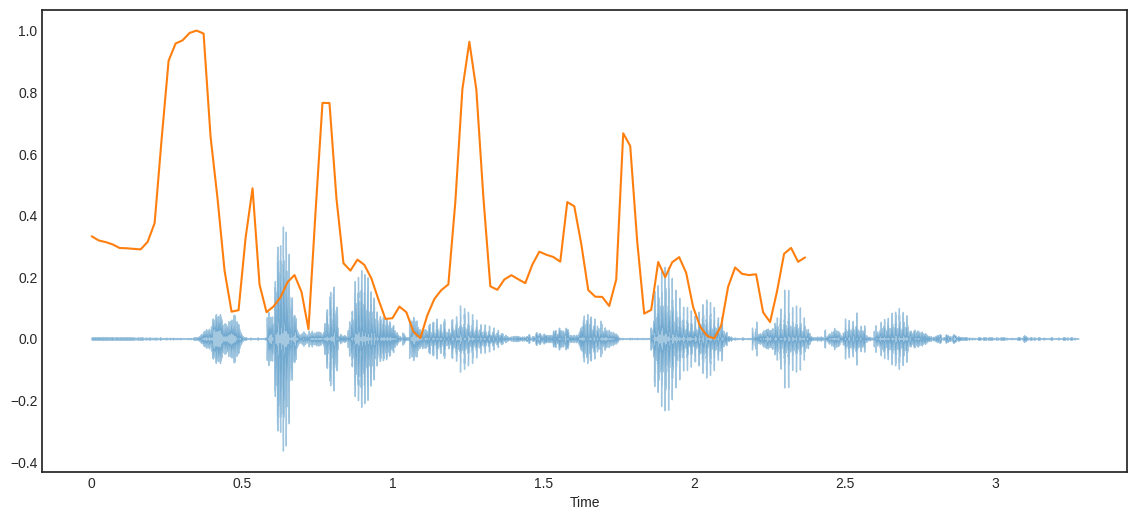

In [ ]:
from sklearn.preprocessing import minmax_scale
plt.figure(figsize = (14, 6))
frames = range(len(spectral_centroids))
t= librosa.frames_to_time(frames)

librosa.display.waveshow(y=audio_np, sr=sr, alpha = 0.4)
plt.plot(t, minmax_scale(spectral_centroids, axis=0))

### 스펙트럼 롤오프(Spectral Rolloff)

* 신호의 모양을 측정
* 고주파수가 0으로 감소하는 주파수를 나타냄

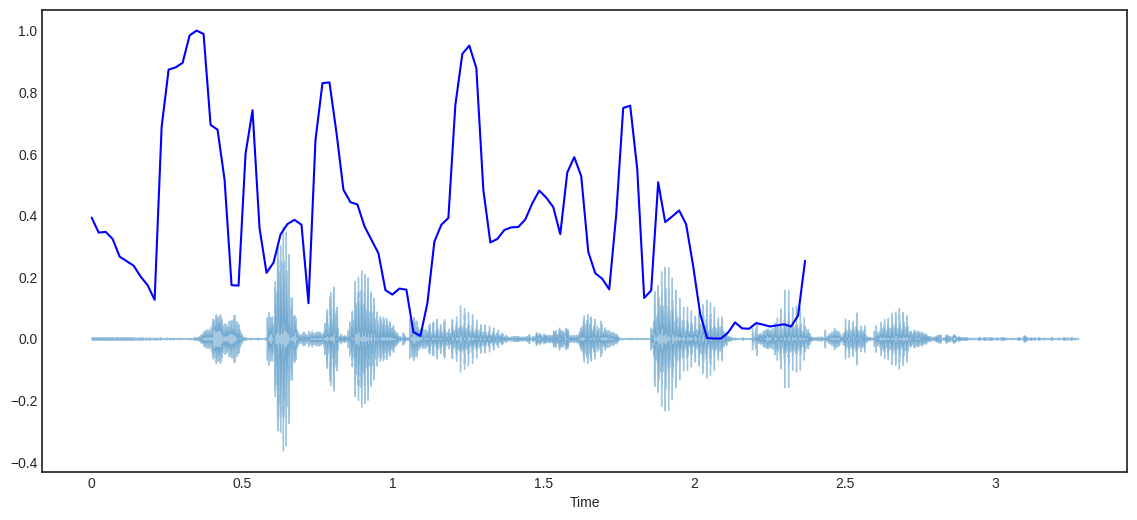

In [ ]:
spectral_rolloff = librosa.feature.spectral_rolloff(y =audio_np+0.01, sr=sr)[0]
plt.figure(figsize=(14, 6))

librosa.display.waveshow(y=audio_np, sr=sr, alpha=0.4 )
plt.plot(t, minmax_scale(spectral_rolloff, axis=0), color = 'b')

### 스펙트럼 대역폭

* 스펙트럼 대역폭은 최대 피크의 절반 (또는 최대 절반의 전체 너비 [FWHM])에서 빛의 대역 폭으로 정의되며 두 개의 수직 빨간색 선과 파장 축에서 λSB로 표시

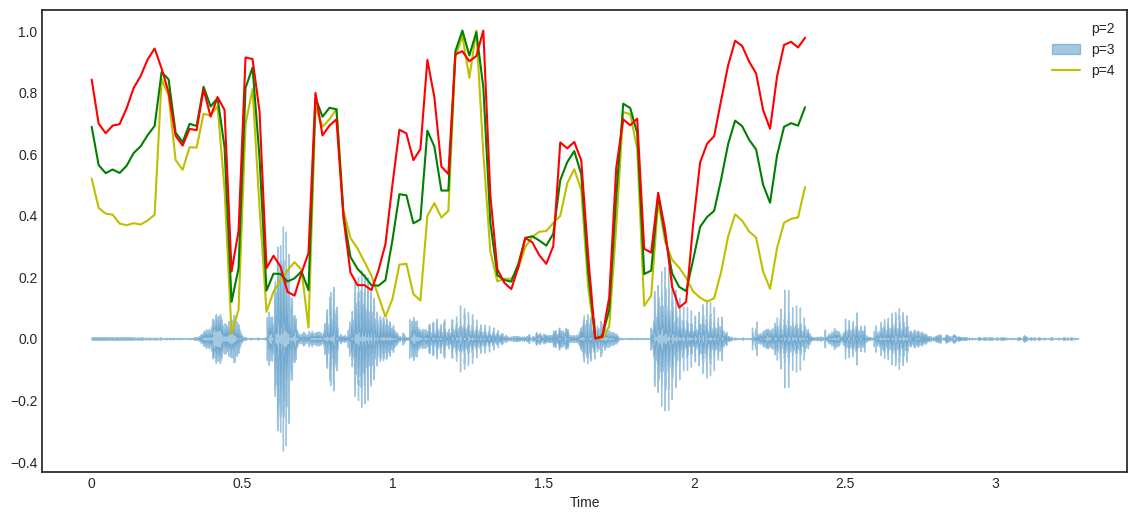

In [ ]:
spectral_bandwidth_2 = librosa.feature.spectral_bandwidth(y=audio_np+0.01, sr=sr)
spectral_bandwidth_3 = librosa.feature.spectral_bandwidth(y=audio_np+0.01, sr=sr, p=3)[0]
spectral_bandwidth_4 = librosa.feature.spectral_bandwidth(y=audio_np+0.01, sr=sr, p=4)[0]
plt.figure(figsize= (14, 6))

librosa.display.waveshow(y=audio_np, sr=sr, alpha=0.4)
plt.plot(t, minmax_scale(spectral_bandwidth_2.squeeze(), axis=0), color='y')
plt.plot(t, minmax_scale(spectral_bandwidth_3.squeeze(), axis=0), color='g')
plt.plot(t, minmax_scale(spectral_bandwidth_4.squeeze(), axis=0), color='r')
plt.legend(('p=2', 'p=3', 'p=4'))


### 제로 크로싱 비율(Zero Crossing Rate)

* 신호의 부드러움을 측정하는 매우 간단한 방법은 해당 신호의 세그먼트 내에서 제로 크로싱 수를 계산하는 것
* 음성 신호는 느리게 진동 (예를 들어, 100Hz 신호는 초당 제로 100을 교차하는 반면 무성 마찰음은 초당 3000 개의 제로 교차를 가질 수 있음)

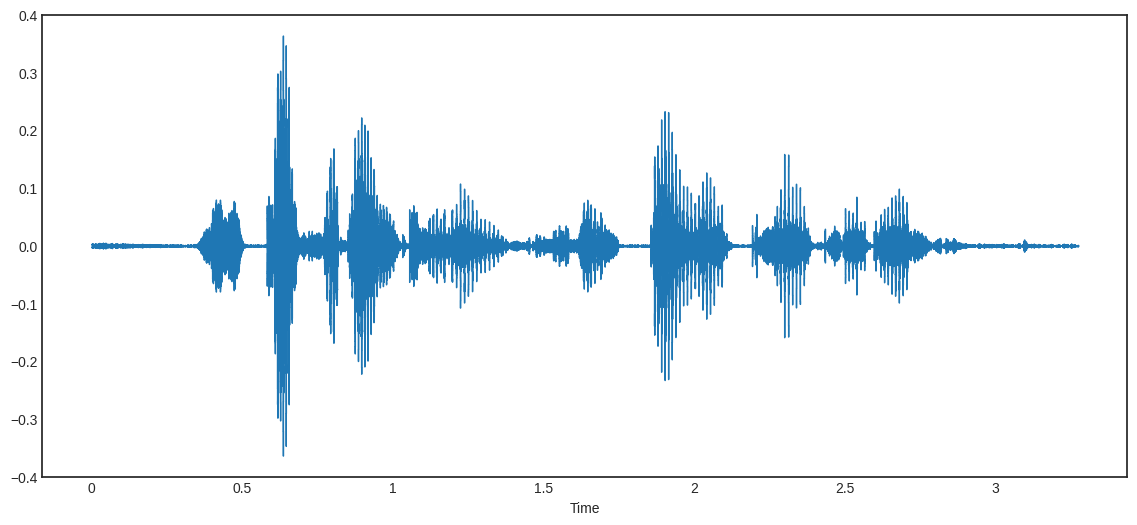

In [ ]:
plt.figure(figsize=(14, 6))
librosa.display.waveshow(audio_np, sr=sr)

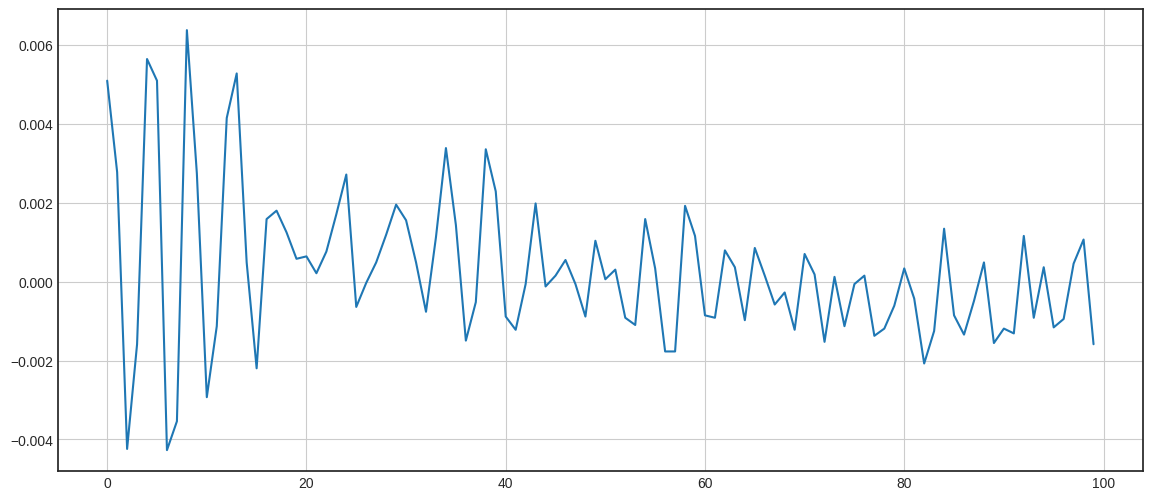

In [ ]:
n0 = 8000
n1 = 8100
plt.figure(figsize=(14, 6))
plt.plot(audio_np[n0:n1])
plt.grid()

In [ ]:
zero_crossings = librosa.zero_crossings(audio_np[n0:n1], pad=False)
print(zero_crossings.shape)
print(sum(zero_crossings))

zcrs = librosa.feature.zero_crossing_rate(audio_np)
print(zcrs.shape)

(100,)
47
(1, 103)


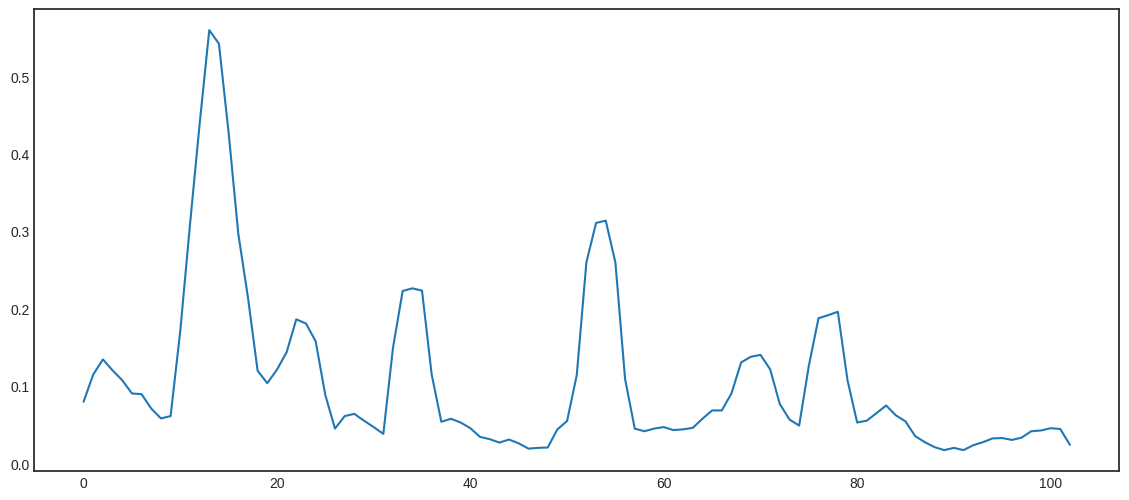

In [ ]:
plt.figure(figsize=(14, 6))
plt.plot(zcrs[0])

### Mel-Frequency Cepstral Coefficients (MFCC)

* 신호의 MFCC(Mel frequency cepstral coefficients)는 스펙트럼 포락선의 전체 모양을 간결하게 설명하는 작은 기능 집합 (일반적으로 약 10-20)
* 인간 목소리의 특성을 모델링

(20, 103)


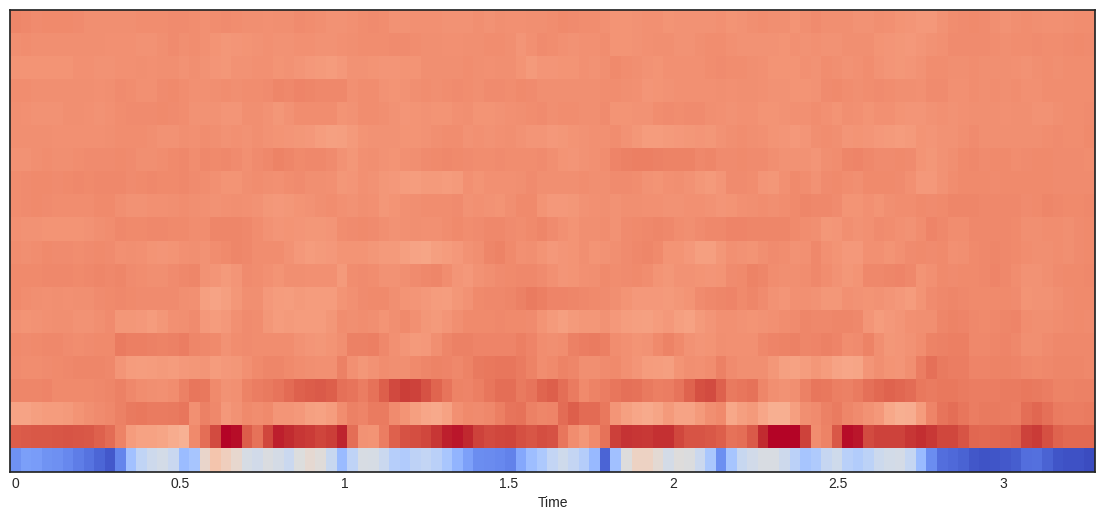

In [ ]:
mfccs = librosa.feature.mfcc(y=audio_np, sr=sr)
print(mfccs.shape)

plt.figure(figsize=(14, 6))
librosa.display.specshow(mfccs, sr=sr, x_axis='time')

### 크로마그램(Chromagram)

* 색도 특성 또는 벡터는  일반적으로 각각의 피치 클래스의 많은 에너지가, {C, C #, D, D 번호는, E, ..., B} 신호 내에 존재하는 방법을 나타내는 요소 특징 벡터
* 음악 작품 간의 유사성 측정을 설명하는 강력한 방법 제공

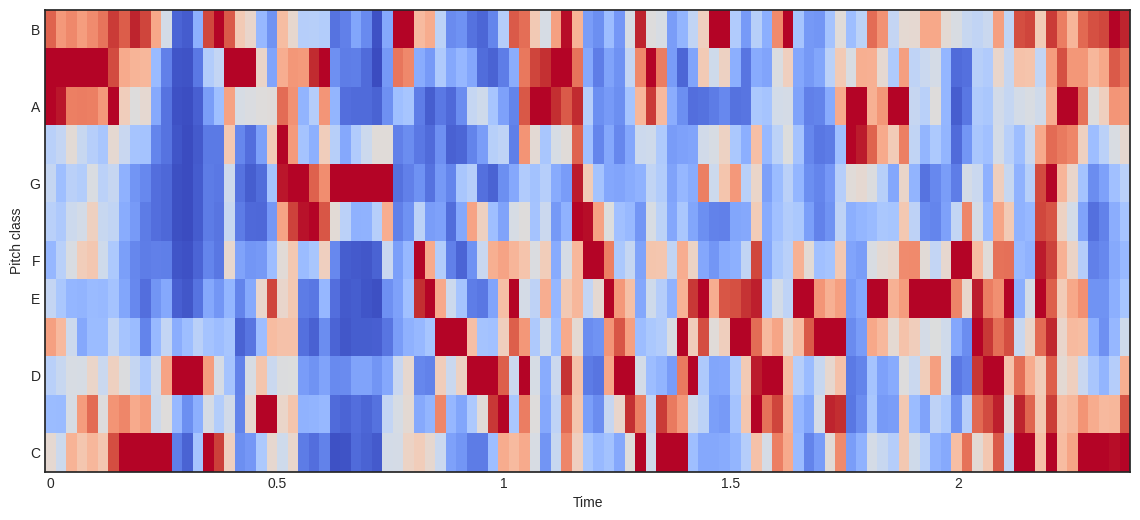

In [ ]:
chromagram = librosa.feature.chroma_stft(y=audio_np, sr=sr, hop_length =512)
plt.figure(figsize = (14, 6))
librosa.display.specshow(chromagram, x_axis='time', y_axis = 'chroma', hop_length=512, cmap='coolwarm')

시간에 따라 어느 피치가 얼만큼 많이 쓰였는지 시각적 정보를 알 수 있음

# 오디오 필터(Audio Filter)

In [ ]:
from scipy.signal import butter, lfilter, freqz

def butter_pass(cutoff, fs, btype, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype=btype, analog = False)
    return b, a

def butter_filter(data, cutoff, fs, btype, order=5):
    b, a = butter_pass(cutoff, fs, btype, order=order)
    y = lfilter(b, a, data)
    return y

In [ ]:
order = 6
fs =16000
cutoff = 2048

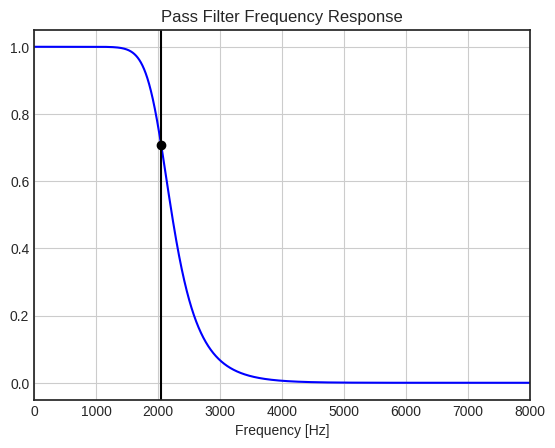

In [ ]:
b, a =butter_pass(cutoff, fs, 'lowpass', order)

w, h = freqz(b, a, worN=8000)

plt.plot(0.5 * fs * w/np.pi, np.abs(h), 'b')
plt.plot(cutoff, 0.5*np.sqrt(2), 'ko')
plt.axvline(cutoff, color = 'k')
plt.xlim(0, 0.5 * fs)
plt.title("Pass Filter Frequency Response")
plt.xlabel('Frequency [Hz]')
plt.grid()

#컷 오프 걸림, 만나는 지점,

프리퀀시 2000 으로 컷오프한 결과 약간 어눌해 짐

In [ ]:
T = len(audio_np) / sr
n = int(T * sr)
t = np.linspace(0, T, n, endpoint=False)

y = butter_filter(audio_np, cutoff, fs, 'lowpass', order)
ipd.Audio(y, rate=fs)

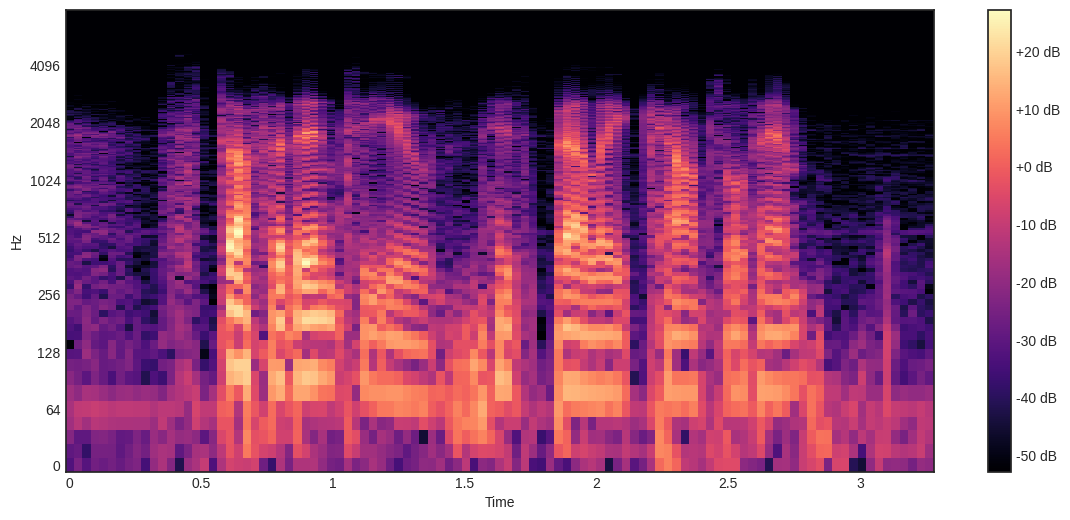

In [ ]:
# 컷오프한 결과 시각화로 나타냄.
X = librosa.core.stft(y, n_fft = 1024, hop_length=512, win_length =1024)
S = librosa.amplitude_to_db(abs(X))
plt.figure(figsize = (14, 6))
librosa.display.specshow(S, sr = fs, hop_length = 512 , x_axis = 'time', y_axis = 'log')
plt.colorbar(format = '%+2.0f dB')

라이브러리 로사,  librosa
https://librosa.org/doc/latest/index.html


공식문서에 필요한 기능들 다루는 방법들


segmentation, clustering, onset detection(스트렝스 체크), feature ectraction(chroma 관련 다양한 종류, rms, contrast, flatness, 템포그램, 푸리에템포그램(리듬피쳐들), inversion 등의 함수들), 다양한 io처리 , 숏타임 푸리에 트랜스폼(stft), 하모닉, 뮤직 노테이션(악보)로 표기할 수 있는 기능, 피치 튜닝, 보컬 separation, 뮤직 싱크